# GPT-2 From Scratch

Learning from Andrej Karpathy's series on LLMs: [Let's reproduce GPT-2 (124M)](https://www.youtube.com/watch?v=l8pRSuU81PU&t=18s)

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 17/11/2025   | Martin | Created   | Notebook created to develop GPT-2 from scratch | 
| 18/11/2025   | Martin | Update   | New components for training GPT-2 section | 
| 24/11/2025   | Martin | Update   | Added more components and additional notes about GPT-2 | 
| 28/11/2025   | Martin | Update   | Added section on algorithmic improvements | 
| 01/12/2025   | Martin | Update   | Added content for distributed learning | 

# Content

* [Introduction](#introduction)
* [Components for Training GPT-2](#components-for-training-gpt-2)
* [Additional Notes](#additional-notes)
* [Improving Training Performance](#improving-training-performance)

# Introduction

First look at the HuggingFace GPT-2 model's architecture

In [1]:
%load_ext watermark

In [2]:
import torch
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, pipeline, set_seed

%matplotlib inline

In [3]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M model
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
  print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

<u>Key Layer Information</u>

- Number of Tokens: 50,257
- Embedding Layer size: 768 
- Context length / Positional encodings: 1,024

Note: Each token is represented as a 768 dimensional vector

In [4]:
# Observe some weights
sd_hf['transformer.wte.weight'].view(-1)[:-20]

tensor([-0.1101, -0.0393,  0.0331,  ...,  0.1461,  0.0323,  0.0128])

Text(0.5, 1.0, 'Each row represents a position. Each column is a channel of that position')

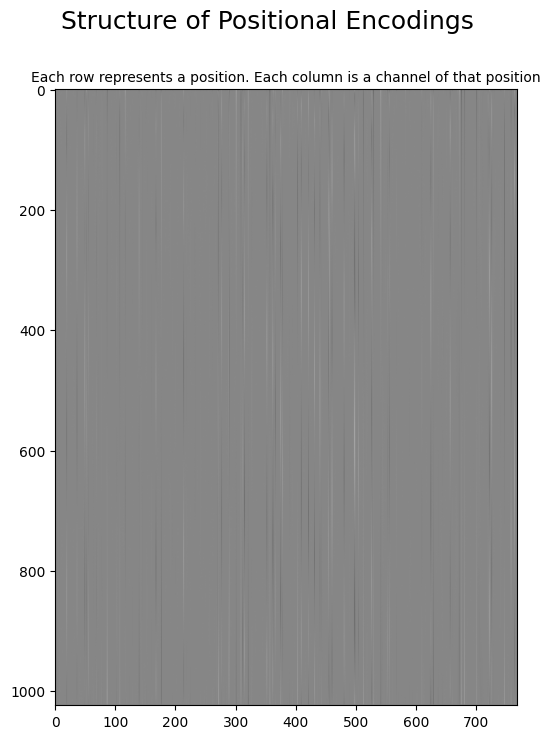

In [5]:
plt.figure(figsize=(15, 8))
plt.imshow(sd_hf['transformer.wpe.weight'], cmap="gray")

plt.suptitle("Structure of Positional Encodings", fontsize=18)
plt.title("Each row represents a position. Each column is a channel of that position", fontsize=10)

Each row represents a position in the context length (max 1,024) as a 768 dimensional matrix. Different areas have darker/ lighter shade representing the size of weights in that channel for that position. Overall the structure learnt here represents how a position has impact on the data.

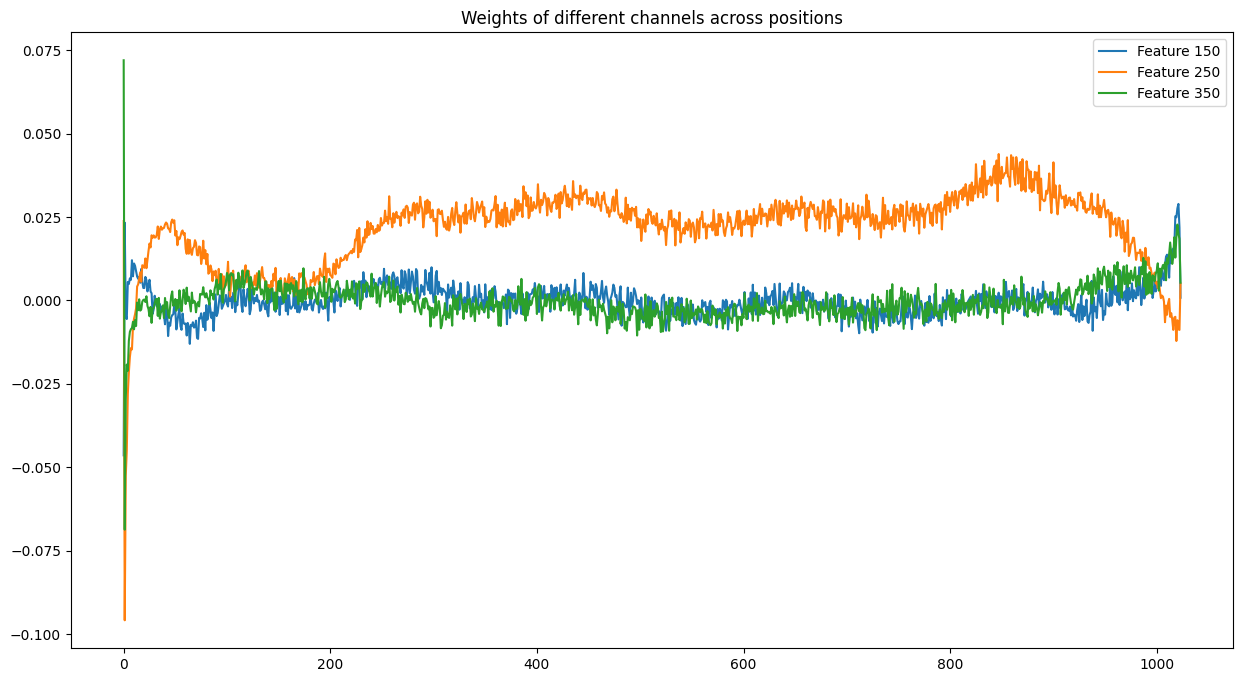

In [6]:
plt.figure(figsize=(15, 8))
plt.plot(sd_hf['transformer.wpe.weight'][:, 150], label="Feature 150")
plt.plot(sd_hf['transformer.wpe.weight'][:, 250], label="Feature 250")
plt.plot(sd_hf['transformer.wpe.weight'][:, 350], label="Feature 350")

plt.title("Weights of different channels across positions")
plt.legend()

Each line represents a __channel's weights__ across the different __positions__. Here the orange line shows higher weights for positions after 400. There is no associated meaning with these values, but it can be compared

The __jagged lines__ shows that the model is slightly undertrained, a better trianed model should be smoother and sinosoidal like

In [7]:
# Test Query
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("The greatest basketball player of all time is", max_length=30, num_return_sequences=5)

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': 'The greatest basketball player of all time is Bill Walton," said Bob Winger, who served as the No. 1 seed in the 2004 NBA draft and also played in the 2004 NBA Finals. "He\'s a great player, too. He\'s a great leader. He\'s a great person. He\'s very emotional. He\'s a leader, a great man."\n\nWalton, who will start for the Wizards, averaged 5.7 points, 4.2 rebounds and 1.0 blocks in 20.2 minutes per game.\n\n"He\'s a great competitor," Wizards coach Randy Wittman said. "He\'s a hard worker. He\'s been through a lot. It was a tough time for people to go through. But he\'s got a lot of energy and a lot of determination. He\'s a great person. He\'s going to do well. He has a lot of talent. He\'s coming out of a tough time. He\'s not going to be a bad basketball player."\n\nWright said Walton has had a "great life."\n\n"He\'s a great basketball player," Wittman said. "He\'s a great leader. He\'s a great person. He\'s very emotional. He\'s a great person."\n\nWalton is

---

# Components for training GPT-2

Various components that feed into training GPT-2

1. Encoding and reshaping the training data
2. Shared weights between final FFN layer and first embedding layer
3. Prevent residual network standard errors from growing out
4. Perform quantisation - reducing FP32 -> FP16. INT8 is used for inference and not for training<sup>*</sup>

<sup>*</sup>INT8 has even spacing between bits, which does not represent the normal distribution well. For training to mimic the normal distribution better, floats are required

In [8]:
import tiktoken

1. Encoding and reshaping training data

- Context length = 6. So each batch will have 6 columns
- The target for token will be the next token in the sequence
- The final token's target must be contained in the targets also

In [9]:
with open('data/shakespeare.txt') as f:
  text = f.read()
data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [10]:
# Encode them using tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [11]:
buf = torch.tensor(tokens[:24+1])
x = buf[:-1].view(-1, 6)
y = buf[1:].view(-1, 6)
print("Training data:")
print(x)
print()
print("Target labels:")
print(y)

Training data:
tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])

Target labels:
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


2. Shared weights

Notice that both have the same values and point to the same memory address

In [19]:
(sd_hf['lm_head.weight'] == sd_hf['transformer.wte.weight']).all()

tensor(True)

In [21]:
print(sd_hf['lm_head.weight'].data_ptr())
print(sd_hf['transformer.wte.weight'].data_ptr())

1675889192915
1675889192915


3. Prevent residual network standard errors from growing

As the residuals accumulate, the standard deviation will continue to grow, so the original GPT paper scales the original standard deviation upon initialisation to be $\frac{1}{\sqrt{N}}$ where $N$ is the number of layers

In [26]:
x = torch.zeros(768)
x_1 = torch.zeros(768)
n = 100               # Number of layers
for i in range(n):
  x += n**-0.5 * torch.randn(768)
  x_1 += torch.randn(768)

print(x.std())
print(x_1.std())

tensor(1.0253)
tensor(9.5344)


---

# Additional Notes

- At model initialisation, all tokens should have the same probability of being selected (assuming uniform distribution). The initial cross entropy loss should be ~$-ln(\frac{1}{n_{tokens}})$. Sanity check to ensure correct initialisation

---

# Improving Training Performance

Various changes to the model to improve training time

## How Tensor Cores work in GPUs

Tensor cores break any computation into 4x4 matrix multiplications

![tensorcores](assets/tensor-cores.png)

- Biggest matrix multiplication (largest computational load) in the GPT-2 model are the linear layers. Particularly the final classification layer 768 -> 50,257

$$tokens\ per\ second=\frac{batch\_size * seq\_len}{t1-t0}$$

✒️NOTE: When training, max out batch size corresponding to hardware

## Quantisation FP32 -> TF32 -> BF16

<u>FP32 -> TF32</u>

- When using `TF32` (not `FP32`) internally the tensor cores are truncating the _mantaissa_ during computation to improve speed at the cost of precision
- A good measure of performance for LLMs: __tokens per sec__: Number of tokens being trained per second

<u>TF32 -> BF16</u>

- BFloat-16 (BF16) reduces the mantaissa further without losing the exponent precision
- Trades-off precision for speed similar to how TF32 works
- _Autocast:_ Process of reducing the precision (quantisation) while in the process of training
  - ⭐ When entering an autocast-enabled region, you should not call `half()` or `bfloat16()` on mdouels or inputs, only within the __context manager__
  - Only surround the forward pass and loss calculation

## `torch.compile`

`torch.compile()` compiles the model and optimises the actions taken to reduce 2 aspects. 

1. "Reducing Python overhead" - Instead of performing commands from top to bottom (in vanilla Python), knowing the entire computation graph, it takes actions that optimally run the code more efficiently in a different order
2. "Reducing GPU read/write" - Data has to constantly be transferred to and from GPU memory to individual cores when each single computations are performed. This ensures that most computation are performed when the data is first transferred to reduce the instances of transfer

## Flash Attention

![flash-attention](assets/flash-attention.png)

- `torch.compile` cannot optimise the Attention block in the current implementation
- (Right side) merges the computation of the Attention block (query * key then value) into a single Flash Attention computation block, so that `torch.compile` can optimise it
- Reduces the amount of I/O between the GPU memory (High-bandwith Memory, HBM) s.t the $N \times N$ ($T \times T$) matrix never materialises - This takes up a huge amount of memory
- Implements an __Online Softmax__ mechanism, where the Softmax values are updated incrementally s.t the large matrix multiplication operation is not required

## Algoritmic improvements

1. Use $\beta_1=0.9$, $\beta_2=0.95$, $\epsilon=10^{-8}$ for optimiser
2. __Clip the global norm__ of gradients (norm is similar to distance of vectors, square all values, sum, then square root) to 1.0. Clipping the gradient norm prevents a "bad batch" from causing large gradient updates since it forces high gradients to 1.0. Tracking this metric is also __recommended__ because it indicates if the model is stable i.e if the gradient norm doesn't vary much between batches
3. Introduce a __learning rate scheduler__ - cosine decay on the learning rate with a min value
4. __Weight decay__ applied to layers that are involved in matmuls. Decaying the weights serves as a regularisation method, by lowering the value of weights, it prevents the model from being too reliant on a single neuron
5. __Increase the batch size__ by creating accumulated gradients. Any batch size can be simulated by accumulating the gradients on smaller micro-batch sizes. This sums the gradients on smaller batch sizes until the target batch size is achieved, and gradients are summed from each smaller batch size. NOTE: Gradient accumulation is a sum in the loss, so must be normalised by the number of accumulation steps

## Distributed Learning

- All GPUs will process different parts of the data in parallel and an additional step that averages the gradients
  - `DistributedData
- Run using `torch.run`
  - Pytorch sets environment variables:
    - `RANK`: The GPU number within the node
    - `LOCAL_RANK`: The GPU node number. Usually it's like VM/ machine number
    - `WORLD_SIZE`: Number of processes running
    - So if 1 box with 8 GPUs, each GPU is assigned a number, node number will be 1 and world size is 8
  - There is a `RANK` value of 0 that defaults to the master process which does the collection of results

In [12]:
%watermark

Last updated: 2025-11-24T16:53:12.633397+08:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.7.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 20
Architecture: 64bit

